# Predicting Home Prices in King’s County, Seattle Using Multilinear Regression

Author: Jake Oddi

## Purpose

The goal for this project was, given a dataset of houses that have sold in King’s County, Seattle between 2014 and 2015, predict the selling prices of similar houses from that area. The predictions will be done on a dataset comprised of houses from the very same county. All of the given features will be the same as in the original dataset as well. They include: Id, date, bedrooms, bathrooms, sqft_living, sqft_lot, sqft_basement, sqft_above, floors, waterfront, view, grade, condition, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, and sale_yr. 

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [2]:
kc = pd.read_csv('kc_house_data_train.csv', index_col = 0)

In [3]:
pd.set_option('display.max_columns', 100)

### Question

What's the relationship between a home's square feet of living space and its price?

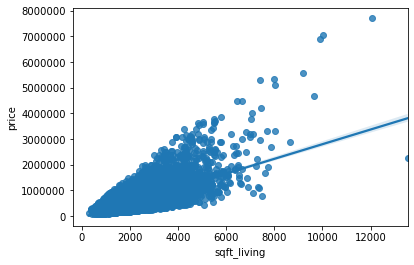

In [4]:
sns.regplot(kc['sqft_living'], kc['price'])

There seems to be a somewhat strong positive association between sqft_living and selling price

### Question

What's the relationship between living squarefeet of the 15 homes surrounding a house and that house's living square feet?

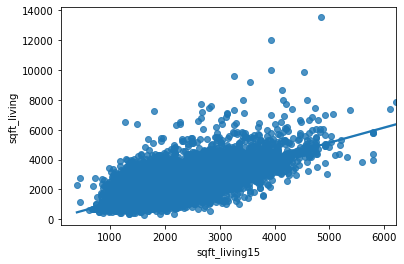

In [5]:
sns.regplot(kc['sqft_living15'], kc['sqft_living'])

There seems to be a somewhat strong positive association between sqft_living15 (average sqft_living of the 15 surrounding homes) and living squarefeet

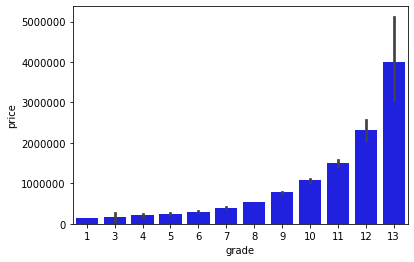

In [6]:
sns.barplot(kc['grade'], kc['price'], color = 'blue')

### Question

The relationship between grade and price doesn't seem to be linear. What happens when we use a log transform on price?

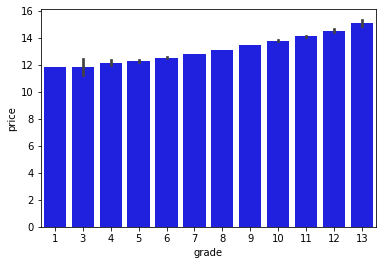

In [7]:
sns.barplot(kc['grade'], np.log(kc['price']), color = 'blue')

As shown in the bar plot above, when we take the log of price, the relationship looks a lot more linear.

## Cleaning

When writing functions to clean this dataset, I had to be careful not to delete rows with values I didn’t like. Instead, I had to impute values of the mean or median for whichever feature I was dealing with. Overall, the dataset did not have many anomalies that required attention, as there were no null values. My most difficult fix was converting the given date string, which was formatted in an odd way, into a datetime object, then accessing different components of that object for feature engineering purposes.

All cleaning functions are done as part of engineering function because some cleaning had to be done after engineering. 

## Feature Engineering

The first two features I created were home_age and yrs_since_renovation. These were the easiest to create and brought the Root Mean Squared Error (RMSE) of my Scikit-Learn linear regression model down to around 200k from around 210k. Next I used one-hot encoding to create dummy variables for each of the 87 zip codes in the dataset, reducing RMSE by 45k.

In [8]:
def engineering_cleaning(dataframe):
    """
    Takes in dataframe, cleans and performs feature engineering, then returns dataframe
    """
    
    dataframe['date'] = dataframe['date'].map(lambda x: x[:8]) # Removes 'T000000' from end of each date
    dataframe['date'] = pd.to_datetime(dataframe['date'], format = '%Y%M%d', errors = 'coerce')


    dataframe['bedrooms'] = np.where((dataframe['bedrooms'] + 1)/(dataframe['bathrooms'] + 1) > 4, 
                                      dataframe['bedrooms'].median(), 
                                      dataframe['bedrooms']) # Taking care of outliers in bedrooms

    dataframe['bathrooms'] = np.where((dataframe['bathrooms'] + 1)/(dataframe['bedrooms'] + 1) > 4,
                                       dataframe['bathrooms'].median(), 
                                       dataframe['bathrooms']) # Taking care of outliers in bathrooms

    dataframe['sale_yr'] = dataframe['date'].dt.year # New column using only year component of date column
    
    dataframe['home_age'] = dataframe['sale_yr'] - dataframe['yr_built']
    
    dataframe['home_age'] = np.where(dataframe['home_age'] == -1, 
                                     0, 
                                     dataframe['home_age']) # Removing rows where year built was after year sold

    dataframe['yr_renovated'] = np.where(dataframe['yr_renovated'] > dataframe['sale_yr'], 
                                         dataframe['sale_yr'], 
                                         dataframe['yr_renovated']) # Removing rows where year renovated was after year sold
        
    dataframe['yrs_since_reno'] = np.where(dataframe['yr_renovated'] != 0, 
                                           dataframe['sale_yr'] - dataframe['yr_renovated'], 
                                           dataframe['home_age']) # Creates yrs_since_reno col depending on if house was renovated

    ohe = pd.get_dummies(dataframe['zipcode']) #step 2 of engineering/cleaning before adding nnp cols
    dataframe = dataframe.join(ohe)
    
    dataframe['sqrt_grade'] = np.sqrt(dataframe['grade'])
    

    
    
    return dataframe

In [9]:
kc = engineering_cleaning(kc)

In [10]:
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_yr,home_age,yrs_since_reno,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,sqrt_grade
0,2591820310,2014-01-06 00:10:00,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427
1,7974200820,2014-01-21 00:08:00,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,37,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427
2,7701450110,2014-01-15 00:08:00,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,17,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.316625
3,9522300010,2015-01-31 00:03:00,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.464102
4,9510861140,2014-01-14 00:07:00,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000


## A First Glance

To better understand the dataset, I used the describe() method on a number of columns, then used a statsmodels OLS function to create an initial regression summary, where I used bedrooms, bathrooms, sqft_living, floors, waterfront, view, condition, yr_built as my predictor variables. Next I wanted to examine correlation within all the features in my dataset, so I used a seaborn pairplot and heatmap. Although multicollinearity is an issue in regression, my goal for this project was to maximize predictability. As a result, even after seeing high Variance Inflation Factors (VIFs) for a number of my predictor variables, I did not remove these variables from my dataset, as doing so reduced my predictability.

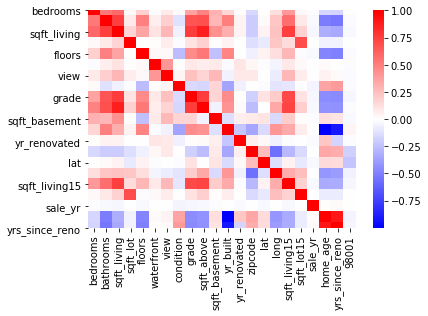

In [11]:
sns.heatmap(kc.iloc[:,3:25].corr(), cmap='bwr')

As shown in the heatmap, a number of variables seem to be correlated. However, through tinkering with different combinations of features, I've found including all of these features achieves the best performance measured by Root Mean Squared Error

## Modeling

Let's see how well a model does without any dummy variables for zip code

In [12]:
X_1 = kc[['bedrooms','bathrooms','sqft_living','sqft_lot',
         'floors','waterfront','view','condition','grade',
         'sqft_above','sqft_basement','sqft_living15',
         'sqft_lot15','home_age','yrs_since_reno']]
y_1 = kc['price']

In [13]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = .2, random_state = 1)

In [14]:
scaler_1 = StandardScaler()

X_train_transformed_1 = scaler_1.fit_transform(X_train_1)   # Fitting and scaling to training data
X_test_transformed_1 = scaler_1.transform(X_test_1)    # Scaling to test data

model_1 = LinearRegression()

model_1.fit(X_train_transformed_1, y_train_1)   

y_pred_1 = model_1.predict(X_test_transformed_1)  

rmse_1 = np.sqrt(sklearn.metrics.mean_squared_error(y_test_1, y_pred_1))

print('R-squared: ' + str(model_1.score(X_test_transformed_1, y_test_1)))
print('RMSE: ' + str(rmse_1))

R-squared: 0.6547451373121134
RMSE: 207896.42634217392


Let's examine the first three coefficients:

In [15]:
model_1.coef_[[2, 7, 8]]

array([ 85645.5784971 ,  10927.66249302, 137979.50232919])

These represent the regression coefficients bathrooms, condition, and grade, respectively.

For every additional bathroom, we can expect the sale price of the house to increase by $85645.57, holding all other variables constant.

For every additional condition point, we can expect the sale price of the house to increase by $10927.66, holding all other variables constant.

For every additional grade point, we can expect the sale price of the house to increase by $137979.50, holding all other variables constant.

Now let's see how well a model with dummy variables for zip code does

In [16]:
predictors = kc.drop(columns = ['id', 'date', 'price', 'zipcode', 'lat', 'long',
                                'yr_renovated', 'sale_yr', 'yr_built'])

In [17]:
X_2 = predictors
y_2 = kc['price']

In [18]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = .2, random_state = 1)

In [19]:
scaler_2 = StandardScaler()

X_train_transformed_2 = scaler_2.fit_transform(X_train_2)   # Fitting and scaling to training data
X_test_transformed_2 = scaler_2.transform(X_test_2)    # Scaling to test data

model_2 = LinearRegression()

model_2.fit(X_train_transformed_2, y_train_2)   

y_pred_2 = model_2.predict(X_test_transformed_2)  

rmse_2 = np.sqrt(sklearn.metrics.mean_squared_error(y_test_2, y_pred_2))

print('R-squared: ' + str(model_2.score(X_test_transformed_2, y_test_2)))
print('RMSE: ' + str(rmse_2))

R-squared: 0.82707560768964
RMSE: 147131.3605879252


RMSE looks a lot better here.

Let's try adding some polynomial features.

In [20]:
poly_feats = predictors[['bedrooms','bathrooms', 'sqft_living','sqft_lot',
                           'floors',     'waterfront',           'view',      'condition',
                           'grade',     'sqft_above',  'sqft_basement',  'sqft_living15',
                           'sqft_lot15',       'home_age', 'yrs_since_reno', 'sqrt_grade']]

In [21]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(poly_feats)
poly2_columns = poly_2.get_feature_names(poly_feats.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,home_age,yrs_since_reno,sqrt_grade,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms home_age,bedrooms yrs_since_reno,bedrooms sqrt_grade,bathrooms^2,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms waterfront,bathrooms view,bathrooms condition,bathrooms grade,bathrooms sqft_above,bathrooms sqft_basement,bathrooms sqft_living15,bathrooms sqft_lot15,bathrooms home_age,bathrooms yrs_since_reno,bathrooms sqrt_grade,sqft_living^2,sqft_living sqft_lot,sqft_living floors,...,view sqft_living15,view sqft_lot15,view home_age,view yrs_since_reno,view sqrt_grade,condition^2,condition grade,condition sqft_above,condition sqft_basement,condition sqft_living15,condition sqft_lot15,condition home_age,condition yrs_since_reno,condition sqrt_grade,grade^2,grade sqft_above,grade sqft_basement,grade sqft_living15,grade sqft_lot15,grade home_age,grade yrs_since_reno,grade sqrt_grade,sqft_above^2,sqft_above sqft_basement,sqft_above sqft_living15,sqft_above sqft_lot15,sqft_above home_age,sqft_above yrs_since_reno,sqft_above sqrt_grade,sqft_basement^2,sqft_basement sqft_living15,sqft_basement sqft_lot15,sqft_basement home_age,sqft_basement yrs_since_reno,sqft_basement sqrt_grade,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 home_age,sqft_living15 yrs_since_reno,sqft_living15 sqrt_grade,sqft_lot15^2,sqft_lot15 home_age,sqft_lot15 yrs_since_reno,sqft_lot15 sqrt_grade,home_age^2,home_age yrs_since_reno,home_age sqrt_grade,yrs_since_reno^2,yrs_since_reno sqrt_grade,sqrt_grade^2
0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,0.0,2390.0,7700.0,28.0,28.0,2.828427,16.0,9.0,8280.0,35572.0,8.0,0.0,0.0,16.0,32.0,8280.0,0.0,9560.0,30800.0,112.0,112.0,11.313708,5.0625,4657.5,20009.25,4.5,0.0,0.0,9.0,18.0,4657.5,0.0,5377.5,17325.0,63.0,63.0,6.363961,4284900.0,18408510.0,4140.0,...,0.0,0.0,0.0,0.0,0.000000,16.0,32.0,8280.0,0.0,9560.0,30800.0,112.0,112.0,11.313708,64.0,16560.0,0.0,19120.0,61600.0,224.0,224.0,22.627417,4284900.0,0.0,4947300.0,15939000.0,57960.0,57960.0,5854.844148,0.0,0.0,0.0,0.0,0.0,0.000000,5712100.0,18403000.0,66920.0,66920.0,6759.940828,59290000.0,215600.0,215600.0,21778.888861,784.0,784.0,79.195959,784.0,79.195959,8.0
1,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,1070.0,2370.0,6283.0,37.0,37.0,2.828427,25.0,15.0,14500.0,33650.0,5.0,0.0,0.0,25.0,40.0,9150.0,5350.0,11850.0,31415.0,185.0,185.0,14.142136,9.0000,8700.0,20190.00,3.0,0.0,0.0,15.0,24.0,5490.0,3210.0,7110.0,18849.0,111.0,111.0,8.485281,8410000.0,19517000.0,2900.0,...,0.0,0.0,0.0,0.0,0.000000,25.0,40.0,9150.0,5350.0,11850.0,31415.0,185.0,185.0,14.142136,64.0,14640.0,8560.0,18960.0,50264.0,296.0,296.0,22.627417,3348900.0,1958100.0,4337100.0,11497890.0,67710.0,67710.0,5176.021638,1144900.0,2535900.0,6722810.0,39590.0,39590.0,3026.417023,5616900.0,14890710.0,87690.0,87690.0,6703.372286,39476089.0,232471.0,232471.0,17771.007625,1369.0,1369.0,104.651804,1369.0,104.651804,8.0
2,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,0.0,3710.0,9685.0,17.0,17.0,3.316625,16.0,10.0,15080.0,43572.0,8.0,0.0,8.0,12.0,44.0,15080.0,0.0,14840.0,38740.0,68.0,68.0,13.266499,6.2500,9425.0,27232.50,5.0,0.0,5.0,7.5,27.5,9425.0,0.0,9275.0,24212.5,42.5,42.5,8.291562,14212900.0,41066610.0,7540.0,...,7420.0,19370.0,34.0,34.0,6.633250,9.0,33.0,11310.0,0.0,11130.0,29055.0,51.0,51.0,9.949874,121.0,41470.0,0.0,40810.0,106535.0,187.0,187.0,36.482873,14212900.0,0.0,13986700.0,36512450.0,64090.0,64090.0,12503.675460,0.0,0.0,0.0,0.0,0.0,0.000000,13764100.0,35931350.0,63070.0,63070.0,12304.677972,93799225.0,164645.0,164645.0,32121.511095,289.0,289.0,56.382621,289.0,56.382621,11.0
3,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,12.0,4560.0,0.0,4050.0,14226.0,25.0,25.0,3

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, kc['price'], random_state=1,test_size=0.2)

In [23]:
scaler_3 = StandardScaler()

scaler_3.fit(X_train)

X_train = pd.DataFrame(data=scaler_3.transform(X_train), columns=df_poly2.columns)

X_test = pd.DataFrame(data=scaler_3.transform(X_test), columns=df_poly2.columns)

In [24]:
model_3 = LinearRegression()

model_3 = model_3.fit(X_train, y_train)

y_pred = model_3.predict(X_test)

test_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))

print('RMSE:' , test_rmse)

RMSE: 183313.25324074354


## Feature Selection Using Filtration by K Best Based on F-Test

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
k = 122
selector = SelectKBest(f_regression, k=k)

selector.fit(X_train, y_train)

SelectKBest(k=122, score_func=<function f_regression at 0x1a1a3ce9d8>)

In [26]:
selected_columns = X_train.columns[selector.get_support()]

In [27]:
model_kbest = LinearRegression()

model_kbest = model_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = model_kbest.predict(X_train[selected_columns])

trainK_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_kbest))

y_kbest = model_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_kbest))

print('RMSE:' , testK_rmse)

RMSE: 183939.18742113683


Because the RMSE is the same after selecting from the polynomials dataset, I will not be using it in the final model. 

## Conclusion

I would have liked to have been able to use K Best Selection on a dataframe with both polynomial features as well as the dummy zip code features, but was unable to get it to work. 